## Main Init

(1912, 1847, 3)
4
False
skipped?:  False
skipped?:  9


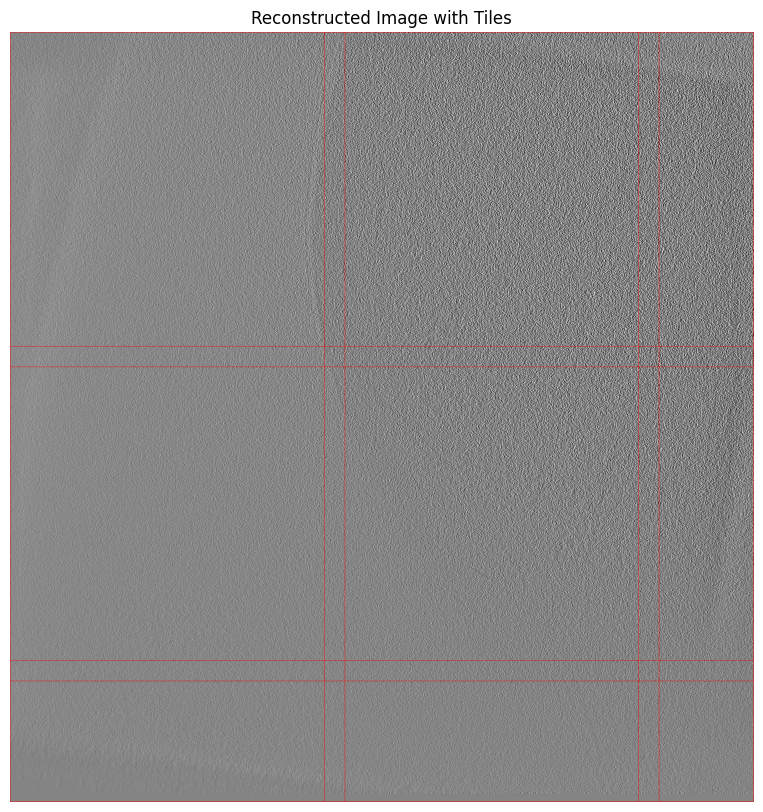

In [ ]:

import glob 

images = sorted(glob.glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True))
image_nps = preload_image_batch(images[:1])
test_image = image_nps[0]
print(test_image.shape)
tiles = split_image_into_tiles(test_image, tile_size=IMAGE_OVER_SIZE_SCALE, overlap=IMAGE_OVERLAP, pad_value=114, min_visible_ratio=0.2)
print(len(result))
print(tile_covers_most_of_image(result[0], test_image.shape, TILE_OVERLAP_SKIP_RATIO))

import matplotlib.pyplot as plt
import cv2
print("skipped?: ", tile_covers_most_of_image(tiles[0], test_image.shape, threshold=TILE_OVERLAP_SKIP_RATIO))
print("skipped?: ",  len(tiles))

def show_image(img, title="Reconstructed Image with Tiles"):
    plt.figure(figsize=(10, 10))
    plt.imshow(img if img.ndim == 3 else img.squeeze(), cmap='gray' if img.ndim == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def reconstruct_image_from_tiles_with_borders(tiles, image_shape, tile_size, overlap, border_color=(255, 0, 0)):
    h, w = image_shape[:2]
    channels = image_shape[2] if len(image_shape) == 3 else 1
    reconstructed = np.zeros((h, w, channels), dtype=np.float32)
    weight = np.zeros((h, w, 1), dtype=np.float32)

    for tile, (x, y) in tiles:
        y_end = min(y + tile_size, h)
        x_end = min(x + tile_size, w)
        tile_crop = tile[:y_end - y, :x_end - x]

        if channels == 1 and tile_crop.ndim == 2:
            tile_crop = tile_crop[..., np.newaxis]

        reconstructed[y:y_end, x:x_end] += tile_crop
        weight[y:y_end, x:x_end] += 1.0

    weight = np.maximum(weight, 1e-5)
    reconstructed /= weight
    reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

    # Draw borders on top of the reconstructed image
    for _, (x, y) in tiles:
        y_end = min(y + tile_size, h)
        x_end = min(x + tile_size, w)
        cv2.rectangle(reconstructed, (x, y), (x_end - 1, y_end - 1), color=border_color, thickness=1)

    return reconstructed    

reconstructed = reconstruct_image_from_tiles_with_borders(tiles, test_image.shape, tile_size=IMAGE_OVER_SIZE_SCALE, overlap=IMAGE_OVERLAP)
show_image(reconstructed)

In [3]:
import cv2
import os
import datetime

def save_prediction_image(image_np, boxes, confs=None, save_dir="./debug"):
    os.makedirs(save_dir, exist_ok=True)

    image_drawn = image_np.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(image_drawn, (x1, y1), (x2, y2), (0, 255, 0), 2)

        if confs is not None:
            conf_text = f"{confs[i]:.2f}"
            text_size = cv2.getTextSize(conf_text, font, font_scale, font_thickness)[0]
            text_x = x1
            text_y = y1 - 5 if y1 - 5 > 10 else y1 + 15  # Avoid clipping
            cv2.putText(image_drawn, conf_text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"prediction_{timestamp}.jpg"
    save_path = os.path.join(save_dir, filename)

    cv2.imwrite(save_path, image_drawn[..., ::-1])  # RGB to BGR for OpenCV
    print(f"[SAVED] {save_path}")


In [12]:
import os
from ultralytics import YOLO
local_dev =  "/workspace/BYU/notebooks" if "WANDB_API_KEY" in os.environ else "C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks"
yolo_dataset_dir = os.path.join(local_dev, 'yolo_dataset')
yolo_weights_dir = os.path.join(local_dev, 'yolo_weights')
yolo_models_dir = os.path.join(local_dev, 'models')

In [17]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import cv2
from tqdm.notebook import tqdm
from ultralytics import YOLO
import threading
import time
from contextlib import nullcontext
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
 
# Detection parameters
CONFIDENCE_THRESHOLD = 0.4  # Lower threshold to catch more potential motors
ZOOM_CONFIDENCE_THRESHOLD = 0.7
MAX_DETECTIONS_PER_SLICE = 1
MAX_DETECTIONS_PER_TOMO = 1  # Keep track of top N detections per tomogram
NMS_IOU_THRESHOLD = 0.4  # Non-maximum suppression threshold for 3D clustering
CONCENTRATION = 0.98 # ONLY PROCESS 1/20 slices for fast submission
BOX_SIZE_PRECENTAGE = 0.10
Z_THRESHOLD = 10
IMAGE_SIZE = 640

IMAGE_OVER_SIZE_PCT = 0.3
IMAGE_OVER_SIZE_SCALE = int(IMAGE_SIZE * (1 + IMAGE_OVER_SIZE_PCT))
SCALE_RATIO = IMAGE_SIZE / IMAGE_OVER_SIZE_SCALE

buffer_factor = 0.1  # More forgiving than perfect alignment
IMAGE_OVERLAP = int(IMAGE_OVER_SIZE_SCALE * (NMS_IOU_THRESHOLD**0.5) * buffer_factor) 
TILE_OVERLAP_SKIP_RATIO = 0.85
TILE_SKIP_EDGE_RATIO = 0.1

BATCH_SIZE = 1  # Default batch size, will be adjusted dynamically if GPU available

ZOOMOUT_SCALES=[0.80, 0.64, 0.50, 0.40]
ZOOMOUT_SCALES_CHECK_COUNT = 2
Z_CONF_RADIUS = 3
Z_CONF_RADIUS_THETA = 0.01

data_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
test_dir = os.path.join(data_path, "test")
submission_path = "/kaggle/working/submission.csv"

# Model path - adjust if your best model is saved in a different location
model_path = "/kaggle/input/shared_010_10/pytorch/default/1/weights/best.pt"
model_path = os.path.join(yolo_weights_dir, "weights", "best.pt")
test_dir= os.path.join(Path(local_dev).parent, "input", "byu-locating-bacterial-flagellar-motors-2025", "test")


## MainCode

In [46]:
# from ultralytics import YOLO
# # 1. 你的 YAML 配置字符串
# # import timm.layers.patch_embed as _pe
# # _pe._assert = lambda cond, msg=None: None
# efficientnet_b5_yolo_config_path = os.path.join(yolo_models_dir, "efficientnet_b5_yolo_config.yaml")

# efficientnet_b5_yolo_config = """
# nc: 1  # number of classes
# backbone:
#   - [-1, 1, Timm, [512, 'efficientnet_b5', True, True, 0, True]]  # Layer 0: returns list of block outputs
#   - [0, 1, Index, [64, 2]]     # Layer 1: P3 = Block 2 output (32x32)
#   - [0, 1, Index, [176, 4]]    # Layer 2: P4 = Block 4 output (16x16)
#   - [0, 1, Index, [512, 6]]    # Layer 3: P5 = Block 6 output (8x8)
#   - [-1, 1, SPPF, [512, 5]]    # Layer 4: SPPF on P5 (8x8) to enhance receptive field

# head:
#   # 上采样/拼接/检测头，通道数建议与 backbone 输出保持一致
#   - [-1, 1, nn.Upsample, [None, 2, 'nearest']]            # 5, SPPF上采样 (8->16)
#   - [[-1, 2], 1, Concat, [1]]                             # 6, 拼接16x16的两个特征
#   - [-1, 3, C2f, [176]]                                   # 7, 通道数和P4对齐

#   - [-1, 1, nn.Upsample, [None, 2, 'nearest']]            # 8, 上采样 (16->32)
#   - [[-1, 1], 1, Concat, [1]]                             # 9, 拼接32x32的两个特征
#   - [-1, 3, C2f, [64]]                                    # 10, 通道数和P3对齐

#   - [-1, 1, Conv, [64, 3, 2]]                             # 11, 下采样 (32->16)
#   - [[-1, 7], 1, Concat, [1]]                             # 12, 拼接16x16的两个特征
#   - [-1, 3, C2f, [176]]                                   # 13

#   - [-1, 1, Conv, [176, 3, 2]]                            # 14, 下采样 (16->8)
#   - [[-1, 4], 1, Concat, [1]]                             # 15, 拼接8x8的两个特征
#   - [-1, 3, C2f, [512]]                                   # 16

#   - [[10, 13, 16], 1, Detect, [nc]]                       # 17, 检测头, 多尺度
# """
# # 2. 写入到本地文件

# with open(efficientnet_b5_yolo_config_path, "w", encoding="utf-8") as f:
#     f.write(efficientnet_b5_yolo_config)

# # 3. 直接用文件路径加载模型结构
# model = YOLO(efficientnet_b5_yolo_config_path, verbose=False)

In [10]:
from collections import defaultdict, namedtuple
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
import cv2

def tile_covers_most_of_image(tile_info, image_shape, threshold=TILE_OVERLAP_SKIP_RATIO):
    tile, (x, y) = tile_info
    tile_h, tile_w = tile.shape[:2]
    img_h, img_w = image_shape[:2]

    # Determine how much area the tile covers relative to full image
    tile_area = tile_w * tile_h
    image_area = img_w * img_h
    coverage_ratio = tile_area / image_area
    # print("DEBUG" ,tile_area, image_area, coverage_ratio)
    return coverage_ratio >= threshold

# Fast zoom-out function using OpenCV
def fast_zoom_out_cv(image_np, scale=0.8, pad_value=114):
    h, w = image_np.shape[:2]
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image_np, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    pad_w = (w - new_w) // 2
    pad_h = (h - new_h) // 2
    pad_left = pad_w
    pad_right = w - new_w - pad_left
    pad_top = pad_h
    pad_bottom = h - new_h - pad_top
    padded_image = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right,
                                      borderType=cv2.BORDER_CONSTANT, value=pad_value)
    return padded_image, pad_w, pad_h

def iou_2d_xyxy(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1[:4]
    x2_min, y2_min, x2_max, y2_max = box2[:4]

    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = max(0, x1_max - x1_min) * max(0, y1_max - y1_min)
    area2 = max(0, x2_max - x2_min) * max(0, y2_max - y2_min)

    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

def weighted_box_fusion_greedy(boxes, iou_threshold=NMS_IOU_THRESHOLD):
    if boxes is None or len(boxes) == 0:
        return None

    fused_boxes = []
    used = [False] * len(boxes)

    for i in range(len(boxes)):
        if used[i]:
            continue

        similar_boxes = [boxes[i]]
        used[i] = True

        for j in range(i + 1, len(boxes)):
            if used[j]:
                continue

            if iou_2d_xyxy(boxes[i], boxes[j]) > iou_threshold:
                similar_boxes.append(boxes[j])
                used[j] = True

        similar_boxes = np.array(similar_boxes)
        confidences = similar_boxes[:, 4]
        weights = confidences / confidences.sum()

        fused_x1 = np.sum(similar_boxes[:, 0] * weights)
        fused_y1 = np.sum(similar_boxes[:, 1] * weights)
        fused_x2 = np.sum(similar_boxes[:, 2] * weights)
        fused_y2 = np.sum(similar_boxes[:, 3] * weights)
        fused_confidence = np.mean(confidences)
        fused_class = int(round(np.mean(similar_boxes[:, 5])))

        fused_boxes.append((fused_x1, fused_y1, fused_x2, fused_y2, fused_confidence, fused_class))

    fused_boxes.sort(key=lambda x: -x[4])
    return [np.array(fused_boxes)] if fused_boxes else None

def predict_ensemble_tta_per_image(model, image_np, zoomout_scales=ZOOMOUT_SCALES, conf=CONFIDENCE_THRESHOLD, from_split = False):
    all_boxes = []
    all_confs = []
    all_clss = []
    
    def predict(tta_img, invert_func):
        boxes_, confs_, clss_ = [], [], []
        results = model.predict(source=tta_img, save=False, verbose=False, conf=conf) # only one images at slice

        for r in results:
            boxes = r.boxes
            if boxes is None or len(boxes) == 0:
                continue
            xyxy = boxes.xyxy.cpu().numpy()
            confs = boxes.conf.cpu().numpy()
            clss = boxes.cls.cpu().numpy().astype(int)
            xyxy_orig = invert_func(xyxy)
            boxes_.append(xyxy_orig)
            confs_.append(confs)
            clss_.append(clss)

        if boxes_:
            boxes_cat = np.concatenate(boxes_, axis=0)
            confs_cat = np.concatenate(confs_, axis=0)
            clss_cat = np.concatenate(clss_, axis=0)
            # print("[DEBUG]predicted:", from_split, len(boxes_))
            return boxes_cat, confs_cat, clss_cat
        else:
            return None, None, None

    def score(confs):
        return confs.sum() if confs is not None else 0
    
    prev_scores = []
    boxes_cat, confs_cat, clss_cat = predict(image_np, invert_func=lambda x: x)
    
    if boxes_cat is not None:
        prev_scores = [score(confs_cat)]
        all_boxes.append(boxes_cat)
        all_confs.append(confs_cat)
        all_clss.append(clss_cat)
    
    if zoomout_scales:
        for idx, zoom in enumerate(zoomout_scales):
            img_zoom_np, pad_w, pad_h = fast_zoom_out_cv(image_np, zoom)

            def invert_zoomout(xyxy):
                xyxy[:, [0, 2]] -= pad_w
                xyxy[:, [1, 3]] -= pad_h
                xyxy /= zoom
                return xyxy
            
            boxes_cat, confs_cat, clss_cat = predict(img_zoom_np, invert_func=invert_zoomout)
            
            if boxes_cat is None:
                if idx < ZOOMOUT_SCALES_CHECK_COUNT and len(all_boxes) == 1:
                    continue
                else:
                    break

            current_score = score(confs_cat)
            if idx >= ZOOMOUT_SCALES_CHECK_COUNT and current_score <= prev_scores[-1]:
                break
            
            save_prediction_image(image_np, boxes_cat) #DEBUG
            prev_scores.append(current_score)
            all_boxes.append(boxes_cat)
            all_confs.append(confs_cat)
            all_clss.append(clss_cat)
    
    if len(all_boxes) == 0:
        return None, None, None
    
    
    boxes_cat = np.concatenate(all_boxes, axis=0)
    confs_cat = np.concatenate(all_confs, axis=0)
    clss_cat = np.concatenate(all_clss, axis=0)
    cat_data = np.column_stack([boxes_cat, confs_cat, clss_cat])

    nms_out = weighted_box_fusion_greedy(cat_data, iou_threshold=NMS_IOU_THRESHOLD)

    print("[DEBUG]predicted:", len(all_boxes), from_split, ", ".join(str(i) for i in zoomout_scales[:idx]))
    
    if not nms_out or nms_out[0] is None or len(nms_out[0]) == 0:
        return None, None, None

    fused = nms_out[0][:MAX_DETECTIONS_PER_SLICE]
    return fused[:, :4], fused[:, 4], fused[:, 5]

# GPU profiling context manager
class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None
        
    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self
        
    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        print(f"[PROFILE] {self.name}: {elapsed:.3f}s")

# Check GPU availability and set up optimizations
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def debug_image_loading(tomo_id):
    """
    Debug function to test image loading methods.
    """
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    if not slice_files:
        print(f"No image files found in {tomo_dir}")
        return
        
    print(f"Found {len(slice_files)} image files in {tomo_dir}")
    sample_file = slice_files[len(slice_files)//2]
    img_path = os.path.join(tomo_dir, sample_file)
    
    try:
        img_pil = Image.open(img_path)
        print(f"PIL Image shape: {np.array(img_pil).shape}, dtype: {np.array(img_pil).dtype}")
        img_cv2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        print(f"OpenCV Image shape: {img_cv2.shape}, dtype: {img_cv2.dtype}")
        img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        print(f"OpenCV RGB Image shape: {img_rgb.shape}, dtype: {img_rgb.dtype}")
        print("Image loading successful!")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        
    try:
        test_model = YOLO(model_path)
        test_results = test_model([img_path], verbose=False)
        print("YOLO model successfully processed the test image")
    except Exception as e:
        print(f"Error with YOLO processing: {e}")
        
if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True
    
    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")
    
    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 2  # Reduce batch size for CPU
        
def normalize_slice(slice_data):
    """
    Normalize slice data using 2nd and 98th percentiles for better contrast
    """
    p2 = np.percentile(slice_data, 2)
    p98 = np.percentile(slice_data, 98)
    clipped_data = np.clip(slice_data, p2, p98)
    normalized = 255 * (clipped_data - p2) / (p98 - p2)
    return np.uint8(normalized)

def preload_image_batch(file_paths):
    """Preload a batch of images to CPU memory"""
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        if img is None:
            # Try with PIL as fallback
            img = np.array(Image.open(path))
        images.append(img)
    return images

def split_image_into_tiles(image_np, tile_size=IMAGE_OVER_SIZE_SCALE, overlap=IMAGE_OVERLAP, pad_value=114, min_visible_ratio=TILE_SKIP_EDGE_RATIO):
    h, w = image_np.shape[:2]
    stride = tile_size - overlap
    tiles = []

    for y in range(0, h, stride):
        for x in range(0, w, stride):
            x_end = x + tile_size
            y_end = y + tile_size

            # Compute visible area
            visible_w = min(w - x, tile_size)
            visible_h = min(h - y, tile_size)
            visible_area = visible_w * visible_h
            total_area = tile_size * tile_size

            # Skip tile if too much is outside bounds
            if visible_area / total_area < min_visible_ratio:
                continue

            tile = image_np[y:y_end, x:x_end]

            # Padding if needed
            pad_bottom = max(0, y_end - h)
            pad_right = max(0, x_end - w)
            pad_top = max(0, -y)
            pad_left = max(0, -x)

            if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
                tile = cv2.copyMakeBorder(tile,
                                          pad_top, pad_bottom, pad_left, pad_right,
                                          cv2.BORDER_CONSTANT, value=pad_value)

            tile = tile[:tile_size, :tile_size]
            tiles.append((tile, (x, y)))

    return tiles

def predict_on_large_image(model, image_np, zoomout_scales, tile_size, overlap):
    tiles = split_image_into_tiles(image_np, tile_size=tile_size, overlap=overlap)
    
    all_global_boxes = []
    all_confs = []
    all_clss = []

    if len(tiles) == 1 or tile_covers_most_of_image(tiles[0], image_np.shape, threshold=TILE_OVERLAP_SKIP_RATIO):
        boxes, confs, clss = predict_ensemble_tta_per_image(model, image_np, zoomout_scales, conf=CONFIDENCE_THRESHOLD, from_split=False)
        if boxes is None:
            return None, None, None
        
        all_global_boxes.append(boxes_global)
        all_confs.append(confs)
        all_clss.append(clss)
        
    else:
        print("[DEBUG] tiles: ", len(tiles))
        for tile, (x_offset, y_offset) in tiles:
            boxes, confs, clss = predict_ensemble_tta_per_image(model, tile, zoomout_scales, conf=ZOOM_CONFIDENCE_THRESHOLD, from_split=True)
            
            if boxes is None:
                continue
            
            # Adjust boxes to global coordinates
            boxes_global = adjust_boxes_to_global_coords(boxes, x_offset, y_offset, SCALE_RATIO)

            all_global_boxes.append(boxes_global)
            all_confs.append(confs)
            all_clss.append(clss)

    # Fuse boxes if we have results
    if all_global_boxes:
        boxes_cat = np.concatenate(all_global_boxes, axis=0)
        confs_cat = np.concatenate(all_confs, axis=0)
        clss_cat = np.concatenate(all_clss, axis=0)
        cat_data = np.column_stack([boxes_cat, confs_cat, clss_cat])  # shape: (N, 6)
        
        # print("[DEBUG]:Tiles: Combine,", len(all_global_boxes))
        nms_out = weighted_box_fusion_greedy(cat_data, iou_threshold=NMS_IOU_THRESHOLD)
        if nms_out and nms_out[0] is not None:
            fused = nms_out[0][:MAX_DETECTIONS_PER_SLICE]
            return fused[:, :4], fused[:, 4], fused[:, 5]

    return None, None, None


def adjust_boxes_to_global_coords(boxes, x_offset, y_offset, scale_ratio):
    boxes = boxes / scale_ratio
    boxes[:, [0, 2]] += x_offset  # x1, x2
    boxes[:, [1, 3]] += y_offset  # y1, y2
    return boxes

def process_tomogram(tomo_id, model, index=0, total=1):
    """
    Process a single tomogram and return the most confident motor detection
    """
    print(f"Processing tomogram {tomo_id} ({index}/{total})")
    
    # Get all slice files for this tomogram
    tomo_dir = os.path.join(test_dir, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    
    # Apply CONCENTRATION to reduce the number of slices processed
    # This will process approximately CONCENTRATION fraction of all slices
    selected_indices = np.linspace(0, len(slice_files)-1, int(len(slice_files) * CONCENTRATION))
    selected_indices = np.round(selected_indices).astype(int)
    # print("[DEBUG] selected_indices", selected_indices.shape, selected_indices)
    slice_files = [slice_files[i] for i in selected_indices]
    
    print(f"Processing {len(slice_files)} out of {len(os.listdir(tomo_dir))} slices based on CONCENTRATION={CONCENTRATION}")
    
    # Create a list to store all detections
    all_detections = []
    
    # Create CUDA streams for parallel processing if using GPU
    if device.startswith('cuda'):
        streams = [torch.cuda.Stream() for _ in range(min(4, BATCH_SIZE))]
    else:
        streams = [None]
    
    # Variables for preloading
    next_batch_thread = None
    next_batch_images = None
    
    # Process slices in batches
    for batch_start in range(0, len(slice_files), BATCH_SIZE):
        # Wait for previous preload thread if it exists
        if next_batch_thread is not None:
            next_batch_thread.join()
            next_batch_images = None
            
        batch_end = min(batch_start + BATCH_SIZE, len(slice_files))
        batch_files = slice_files[batch_start:batch_end]
        
        # Start preloading next batch
        next_batch_start = batch_end
        next_batch_end = min(next_batch_start + BATCH_SIZE, len(slice_files))
        next_batch_files = slice_files[next_batch_start:next_batch_end] if next_batch_start < len(slice_files) else []
        
        if next_batch_files:
            next_batch_paths = [os.path.join(tomo_dir, f) for f in next_batch_files]
            next_batch_thread = threading.Thread(target=preload_image_batch, args=(next_batch_paths,))
            next_batch_thread.start()
        else:
            next_batch_thread = None
        
        # Split batch across streams for parallel processing
        sub_batches = np.array_split(batch_files, len(streams))
        sub_batch_results = []
        
        for i, sub_batch in enumerate(sub_batches):
            if len(sub_batch) == 0:
                continue
                
            stream = streams[i % len(streams)]
            with torch.cuda.stream(stream) if stream and device.startswith('cuda') else nullcontext():
                # Process sub-batch
                sub_batch_paths = [os.path.join(tomo_dir, slice_file) for slice_file in sub_batch]
                sub_batch_slice_nums = [int(slice_file.split('_')[1].split('.')[0]) for slice_file in sub_batch]
                
                results = []
                # Run inference with profiling
                with GPUProfiler(f"Inference batch {i+1}/{len(sub_batches)}"):
                    image_nps = preload_image_batch(sub_batch_paths)
                    for img_np in image_nps:
                        if img_np.shape[0] > IMAGE_OVER_SIZE_SCALE or img_np.shape[1] > IMAGE_OVER_SIZE_SCALE:
                            results.append(predict_on_large_image(model, img_np, ZOOMOUT_SCALES, IMAGE_OVER_SIZE_SCALE, IMAGE_OVERLAP))
                        else:
                            results.append(predict_ensemble_tta_per_image(model, img_np, ZOOMOUT_SCALES))

                for j, (boxes, confs, clss) in enumerate(results):
                    if boxes is None:
                        continue

                    for box_idx, confidence in enumerate(confs):
                        if confidence >= CONFIDENCE_THRESHOLD:
                            x1, y1, x2, y2 = boxes[box_idx]
                            all_detections.append({
                                'z': int(sub_batch_slice_nums[j]),
                                'y1': round(y1),
                                'y2': round(y2),
                                'x1': round(x1),
                                'x2': round(x2),
                                'confidence': float(confidence)
                            })
        
        # Synchronize streams
        if device.startswith('cuda'):
            torch.cuda.synchronize()
    
    # print("[DEBUG]all_detections: ", len(all_detections))
    # Clean up thread if still running
    if next_batch_thread is not None:
        next_batch_thread.join()
    
    # 3D Non-Maximum Suppression to merge nearby detections across slices
    final_detections = perform_3d_nms(all_detections, NMS_IOU_THRESHOLD, Z_THRESHOLD)

    # If there are no detections, return NA values
    if not final_detections:
        return {
            'tomo_id': tomo_id,
            'Motor axis 0': -1,
            'Motor axis 1': -1,
            'Motor axis 2': -1
        }
    
    # Take the detection with highest confidence
    best_detection = final_detections[0]
    
    # Return result with integer coordinates
    return {
        'tomo_id': tomo_id,
        'Motor axis 0': round(best_detection['z']),
        'Motor axis 1': round(best_detection['y']),
        'Motor axis 2': round(best_detection['x'])
    }

def perform_3d_nms(detections_with_z, iou_threshold=NMS_IOU_THRESHOLD, z_threshold=Z_THRESHOLD):
    if not detections_with_z:
        return []

    fused_boxes = []
    used = [False] * len(detections_with_z)

    for i in range(len(detections_with_z)):
        if used[i]:
            continue

        z_i = detections_with_z[i]['z']
        box_i = [
            detections_with_z[i]['x1'], detections_with_z[i]['y1'],
            detections_with_z[i]['x2'], detections_with_z[i]['y2'],
            detections_with_z[i]['confidence'], z_i
        ]
        similar_boxes = [box_i]
        used[i] = True

        for j in range(i + 1, len(detections_with_z)):
            if used[j]:
                continue

            z_j = detections_with_z[j]['z']
            if abs(z_i - z_j) > z_threshold:
                continue

            box_j = [
                detections_with_z[j]['x1'], detections_with_z[j]['y1'],
                detections_with_z[j]['x2'], detections_with_z[j]['y2'],
                detections_with_z[j]['confidence'], z_j
            ]
            if iou_2d_xyxy(box_i, box_j) > iou_threshold:
                similar_boxes.append(box_j)
                used[j] = True

        similar_boxes = np.array(similar_boxes)
        confidences = similar_boxes[:, 4]
        z_values = similar_boxes[:, 5]
        support_counts = np.array([
            np.sum(np.abs(z_values - z) <= Z_CONF_RADIUS) for z in z_values
        ])
        combined_weight = confidences + support_counts * Z_CONF_RADIUS_THETA
        weights = combined_weight / combined_weight.sum()

        fused_x1 = np.sum(similar_boxes[:, 0] * weights)
        fused_y1 = np.sum(similar_boxes[:, 1] * weights)
        fused_x2 = np.sum(similar_boxes[:, 2] * weights)
        fused_y2 = np.sum(similar_boxes[:, 3] * weights)
        fused_confidence = np.mean(confidences)
        fused_z = int(round(np.mean(similar_boxes[:, 5])))

        x_center = (fused_x1 + fused_x2) / 2
        y_center = (fused_y1 + fused_y2) / 2

        fused_boxes.append({
            'x': round(x_center),
            'y': round(y_center),
            'z': fused_z,
            'confidence': float(fused_confidence),
        })

    fused_boxes.sort(key=lambda x: -x['confidence'])
    # print("[DEBUG]fused_boxes: ", len(fused_boxes))
    return fused_boxes[:MAX_DETECTIONS_PER_TOMO]


Using GPU: NVIDIA GeForce RTX 3080 Ti with 12.88 GB memory
Dynamic batch size set to 32 based on 12.88GB free memory


In [11]:
def generate_submission():
    """
    Main function to generate the submission file
    """
    # Get list of test tomograms
    test_tomos = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    total_tomos = len(test_tomos)
    
    print(f"Found {total_tomos} tomograms in test directory")
    
    # Debug image loading for the first tomogram
    if test_tomos:
        debug_image_loading(test_tomos[0])
    
    # Clear GPU cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Initialize model once outside the processing loop
    print(f"Loading YOLO model from {model_path}")
    model = YOLO(model_path)
    model.to(device)
    
    # Additional optimizations for inference
    if device.startswith('cuda'):
        # Fuse conv and bn layers for faster inference
        model.fuse()
        
        # Enable model half precision (FP16) if on compatible GPU
        if torch.cuda.get_device_capability(0)[0] >= 7:  # Volta or newer
            model.model.half()
            print("Using half precision (FP16) for inference")
    
    # Process tomograms with parallelization
    results = []
    motors_found = 0
    
    # Using ThreadPoolExecutor with max_workers=1 since each worker uses the GPU already
    # and we're parallelizing within each tomogram processing
    with ThreadPoolExecutor(max_workers=1) as executor:
        future_to_tomo = {}
        
        # Submit all tomograms for processing
        for i, tomo_id in enumerate(test_tomos, 1):
            future = executor.submit(process_tomogram, tomo_id, model, i, total_tomos)
            future_to_tomo[future] = tomo_id
        
        # Process completed futures as they complete
        for future in future_to_tomo:
            tomo_id = future_to_tomo[future]
            try:
                # Clear CUDA cache between tomograms
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
                result = future.result()
                results.append(result)
                
                # Update motors found count
                has_motor = not pd.isna(result['Motor axis 0'])
                if has_motor:
                    motors_found += 1
                    print(f"Motor found in {tomo_id} at position: "
                          f"z={result['Motor axis 0']}, y={result['Motor axis 1']}, x={result['Motor axis 2']}")
                else:
                    print(f"No motor detected in {tomo_id}")
                    
                print(f"Current detection rate: {motors_found}/{len(results)} ({motors_found/len(results)*100:.1f}%)")
            
            except Exception as e:
                print(f"Error processing {tomo_id}: {e}")
                # Create a default entry for failed tomograms
                results.append({
                    'tomo_id': tomo_id,
                    'Motor axis 0': -1,
                    'Motor axis 1': -1,
                    'Motor axis 2': -1
                })
    
    # Create submission dataframe
    submission_df = pd.DataFrame(results)
    
    # Ensure proper column order
    submission_df = submission_df[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
    
    # Save the submission file

    
    print(f"\nSubmission complete!")
    print(f"Motors detected: {motors_found}/{total_tomos} ({motors_found/total_tomos*100:.1f}%)")
    
start_time = time.time()

# Generate submission
submission = generate_submission()

# Print total execution time
elapsed = time.time() - start_time
print(f"\nTotal execution time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
    
    

Found 3 tomograms in test directory
Found 500 image files in C:\Users\Freedomkwok2022\ML_Learn\BYU\input\byu-locating-bacterial-flagellar-motors-2025\test\tomo_003acc
PIL Image shape: (1912, 1847), dtype: uint8
OpenCV Image shape: (1912, 1847, 1), dtype: uint8
OpenCV RGB Image shape: (1912, 1847, 3), dtype: uint8
Image loading successful!
Error with YOLO processing: [Errno 2] No such file or directory: 'C:\\Users\\Freedomkwok2022\\ML_Learn\\BYU\\notebooks\\yolo_weights\\import os \\weights\\best.pt'
Loading YOLO model from C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\yolo_weights\import os \weights\best.pt


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Freedomkwok2022\\ML_Learn\\BYU\\notebooks\\yolo_weights\\import os \\weights\\best.pt'

### Helper

In [9]:
large_image = os.path.join(local_dev, "cleaned", "images", "shared_009_cleaned", "train", "cryoet_007_mba2011-08-10-41_z0062_y0300_x0216_w0512_h0512_r300.jpg")

if os.path.exists(large_image):
    print(large_image)

C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks\cleaned\images\shared_009_cleaned\train\cryoet_007_mba2011-08-10-41_z0062_y0300_x0216_w0512_h0512_r300.jpg


## Local Test

In [32]:
model_009_merge_159 = os.path.join(yolo_weights_dir, "10_yolo11s_shared_010_cleaned_248_80", "weights", "best.pt")
model = YOLO(model_009_merge_159)
result = predict_ensemble_tta_per_image(model, preload_image_batch([large_image])[0], ZOOMOUT_SCALES)

[DEBUG]predicted: 1
[DEBUG]zoomout_scales: 0.8
[DEBUG]predicted: 1
[DEBUG]zoomout_scales: 0.567
[DEBUG]predicted: 1
[DEBUG]zoomout_scales: 0.4
[DEBUG]predicted: 1
[DEBUG]predicted: 3


In [35]:
result

(array([[     166.31,      272.85,      216.78,      323.42]]),
 array([    0.69254]),
 array([          0]))

## Submission Test